
# Logistic Regression Classifier

Logistic regression is a statistical method for analyzing a dataset in which there are one or more independent variables that determine an outcome. The outcome is measured with a dichotomous variable (in which there are only two possible outcomes). It is used extensively in various fields including machine learning, medical statistics, and social sciences.

This notebook will guide you through the basics of logistic regression, its advantages and disadvantages, and provide an implementation example using Python's Scikit-learn library.



## Theory

Logistic regression models the probability that a given input point belongs to a certain class. The model uses the logistic function (also known as the sigmoid function) to map the output to a probability value between 0 and 1.

The logistic function is defined as:
$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

The hypothesis for logistic regression is defined as:
$$
h_\theta(x) = \sigma(\theta^T x)
$$

The cost function for logistic regression is the log-loss function:
$$
J(\theta) = -\frac{1}{m} \sum_{i=1}^{m} [y^{(i)} \log(h_\theta(x^{(i)})) + (1 - y^{(i)}) \log(1 - h_\theta(x^{(i)}))]
$$

We optimize this cost function using methods such as gradient descent to find the parameters (\theta) that minimize the cost.



## Advantages and Disadvantages

**Advantages:**
- **Interpretability:** The coefficients of the model can be interpreted as the log odds of the outcome.
- **Efficiency:** Logistic regression is computationally efficient and performs well with linearly separable datasets.
- **Probabilistic Output:** It provides a probability score for observations.

**Disadvantages:**
- **Linearity Assumption:** Assumes a linear relationship between the input variables and the log odds of the outcome.
- **Outliers Sensitivity:** Logistic regression can be sensitive to outliers.
- **Multicollinearity:** Highly correlated independent variables can affect the performance.



## Applications

Logistic regression is widely used in various fields:
- **Medical:** Predicting the presence or absence of a disease.
- **Marketing:** Determining if a customer will buy a product.
- **Finance:** Credit scoring to assess the risk of default.



## Implementation

We will implement logistic regression using the Scikit-learn library. The steps include:
1. Loading and preprocessing the data.
2. Training the logistic regression model.
3. Evaluating the model using appropriate metrics.
4. Performing hyperparameter tuning.


In [23]:
# Standard libraries
import math
import logging
from collections import Counter

# Data handling and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn libraries for preprocessing and metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# Scikit-learn libraries for model selection
from sklearn.model_selection import GridSearchCV, KFold, cross_validate, train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score

# Scikit-learn libraries for models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Scikit-learn libraries for pipeline
from sklearn.pipeline import make_pipeline

# Imbalanced-learn libraries
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import Pipeline


from sklearn import metrics
#debugging stuff
from typing import Tuple, Optional, Dict, Any
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()



In [24]:
def initialize_data() -> Tuple[pd.DataFrame, pd.Series]:
    # Load data from CSV files
    X = pd.read_csv('wineData.csv')
    y = pd.read_csv('wineRatings.csv')
    y = y.values.ravel()
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    # Log data information
    logging.info(f"X shape: {X.shape}, y shape: {y.shape}")
    return X, y

In [25]:

def sampling_strategy(y):
    unique, counts = np.unique(y, return_counts=True)
    max_count = max(counts)
    return {class_label: max(int(0.10 * max_count), count) for class_label, count in zip(unique, counts)}

def initialize_and_split_data():
    X, y = initialize_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    strategy = sampling_strategy(y_train)
    oversampler = SMOTE(sampling_strategy=strategy, k_neighbors=2, random_state=42)
    X_train, y_train = oversampler.fit_resample(X_train, y_train)
    return X_train, X_test, y_train, y_test

def evaluate_model(X_train, y_train, model, cv_splits, random_state=None):
    scores = cross_val_score(model, X_train, y_train, cv=cv_splits)
    mean_accuracy = scores.mean()
    return mean_accuracy, scores

def optimize_hyperparameters(X_train, y_train, estimator, param_grid, n_iter=50, cv_splits=5, random_state=None):
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    randomized_search = RandomizedSearchCV(estimator, param_grid, n_iter=n_iter, cv=cv, scoring='accuracy', random_state=random_state)
    randomized_search.fit(X_train, y_train)
    return randomized_search.best_params_

def cross_validation_with_optimized_hyperparameters(X_train, y_train, model, best_params, cv_splits=5, random_state=None):
    model.set_params(**best_params)
    mean_accuracy, scores = evaluate_model(X_train, y_train, model, cv_splits, random_state)
    return mean_accuracy, scores

def evaluate_initial_model(X, y, model, cv_splits=5, random_state=None):
    X_train, X_test, y_train, y_test = initialize_and_split_data(X, y, test_size=0.2, random_state=random_state)
    mean_accuracy, scores = evaluate_model(X_train, y_train, model, cv_splits, random_state)
    return mean_accuracy, scores, X_test, y_test

In [26]:

def generate_report(y_test: Any, y_pred: Any) -> Dict[str, Any]:
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)
    logging.info("Classification report:\n%s", classification_report(y_test, y_pred, zero_division=1))
    logging.info("Confusion matrix:\n%s", confusion_matrix(y_test, y_pred))
    return report

def plot_class_probabilities(y_test: Any, y_prob: np.ndarray, ax: plt.Axes) -> None:
    for i in range(y_prob.shape[1]):
        pd.DataFrame({'Actual': (y_test == i), 'Predicted Probability': y_prob[:, i]}).sort_values(by='Predicted Probability').reset_index(drop=True).plot(ax=ax)
    ax.set_title('Actual vs Predicted Probability for each class')
    ax.set_xlabel('Index (sorted by predicted probability)')
    ax.set_ylabel('Probability')
    ax.legend([f'Class {i}' for i in range(y_prob.shape[1])])

def plot_actual_vs_predicted(y_test: Any, y_pred: Any, ax: plt.Axes) -> None:
    pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).plot(ax=ax, marker='o')
    ax.set_title('Actual vs Predicted values')
    ax.set_xlabel('Index')
    ax.set_ylabel('Values')
    ax.legend(['Actual', 'Predicted'])

def plot_confusion_matrix(y_test: Any, y_pred: Any, ax: plt.Axes, class_labels: list) -> None:
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, xticklabels=class_labels, yticklabels=class_labels)
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

def plot_classification_report(report: Dict[str, Any], ax: plt.Axes) -> None:
    report_df = pd.DataFrame(report).transpose().drop(columns='support')
    report_df.plot(kind='bar', ax=ax)
    ax.set_title('Classification Report Metrics')
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Score')
    ax.set_ylim(0, 1)
    ax.legend(loc='lower right')

def display_plots(y_fold_test: np.ndarray, y_pred: np.ndarray, report: Dict[str, Any], cv_results: Dict[str, Any], accuracy_without_optimization: float, accuracy_with_optimization: float, class_labels: list) -> None:
    fig, axs = plt.subplots(3, 2, figsize=(16, 16))
    
    plot_actual_vs_predicted(y_fold_test, y_pred, axs[0, 0])
    plot_confusion_matrix(y_fold_test, y_pred, axs[0, 1], class_labels)
    plot_classification_report(report, axs[1, 0])
    
    axs[1, 1].plot(cv_results['test_score'], label='Test Score')
    axs[1, 1].plot(cv_results['train_score'], label='Train Score')
    axs[1, 1].set_title('Cross-validation Results with Optimized Hyperparameters')
    axs[1, 1].set_xlabel('Fold Index')
    axs[1, 1].set_ylabel('Accuracy')
    axs[1, 1].legend()

    axs[2, 0].bar(['Without Optimization', 'With Optimization'], [accuracy_without_optimization, accuracy_with_optimization])
    axs[2, 0].set_title('Comparison of Model Performance')
    axs[2, 0].set_ylabel('Mean Accuracy Score')
    
    plt.tight_layout()
    plt.show()

INFO:root:X shape: (1503, 5), y shape: (1503,)
INFO:root:X shape: (1503, 5), y shape: (1503,)
INFO:root:Best hyperparameters: {'tol': 0.0001, 'solver': 'lbfgs', 'penalty': 'l2', 'class_weight': None, 'C': 0.615848211066026}
INFO:root:Mean accuracy: 0.5618688455897759
INFO:root:Scores: [0.52509653 0.54054054 0.55984556 0.56370656 0.62015504]
INFO:root:Classification report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        13
           5       0.67      0.76      0.71       120
           6       0.52      0.65      0.58       114
           7       0.60      0.17      0.27        52
           8       0.00      1.00      0.00         0

    accuracy                           0.58       301
   macro avg       0.30      0.43      0.26       301
weighted avg       0.57      0.58      0.55       301

INFO:root:Confusion matrix:
[[ 0  1  1  0  0  0]
 [ 1  0  9  3  0  0]
 [ 2  0 91 

MAE: 0.44518272425249167
MSE: 0.49169435215946844
RMSE: 0.701209207126852
R2: 0.29111104038700253


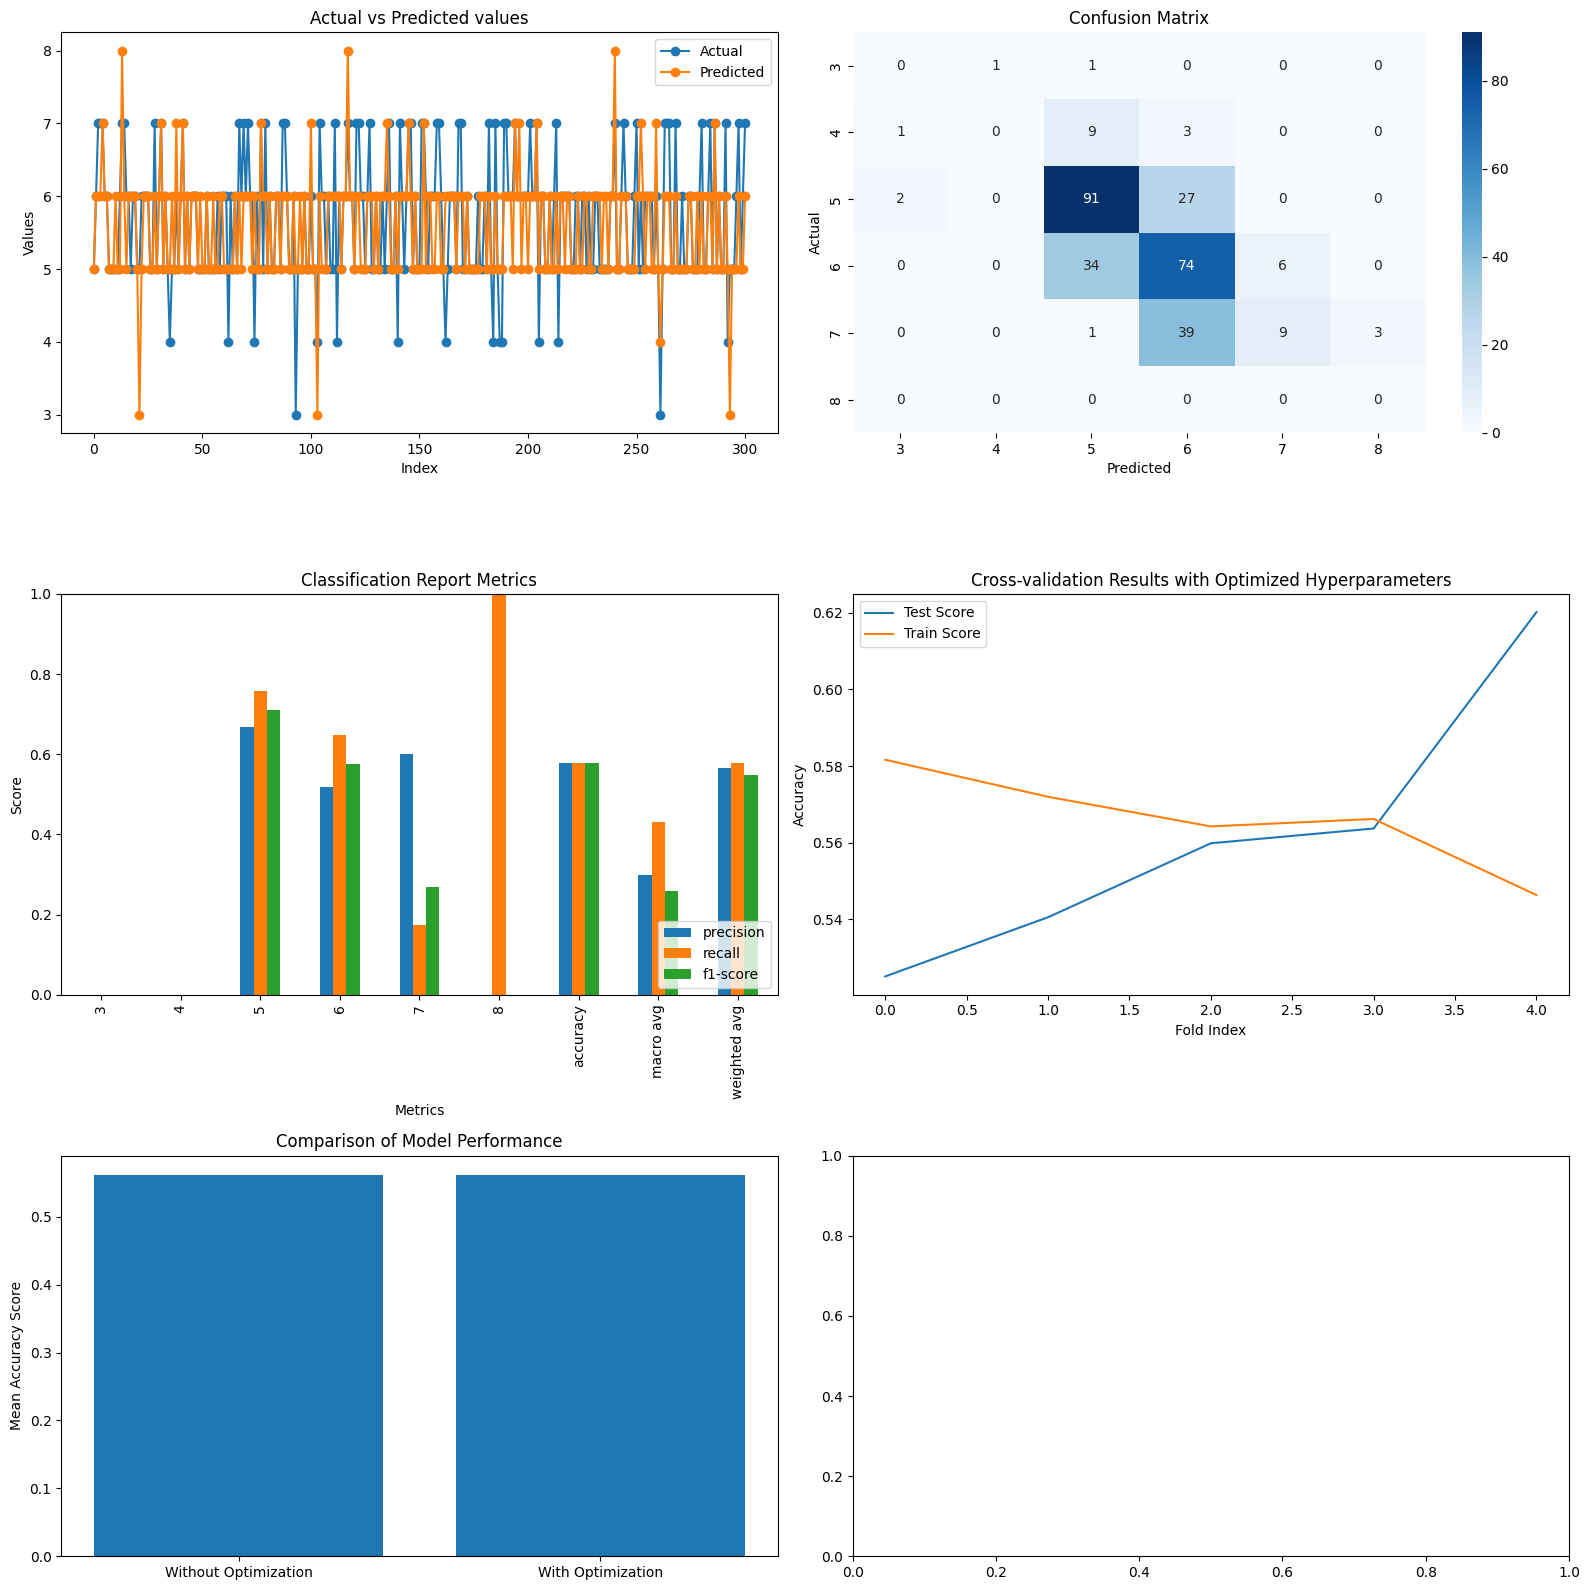

In [27]:

#Logistic regression classificator with weighted classes
def perform_hyperparameter_optimization(X_train, y_train, model):
    param_grid = {
        'C': np.logspace(-4, 4, 20),
        'penalty': ['l2'],
        'solver': ['liblinear', 'lbfgs', 'newton-cg'],
        'class_weight': [None, 'balanced'],
        'tol': [1e-4, 1e-3, 1e-2, 1e-1]
    }
    best_params = optimize_hyperparameters(X_train, y_train, model, param_grid, n_iter=50, cv_splits=5, random_state=42)
    logger.info(f"Best hyperparameters: {best_params}")
    return best_params


def cross_validate_with_optimized_params(X_train, y_train, model, best_params):
    model.set_params(**best_params)
    mean_accuracy, scores = cross_validation_with_optimized_hyperparameters(X_train, y_train, model, best_params, cv_splits=5, random_state=42)
    return mean_accuracy, scores

def generate_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=1)
    logger.info(f"Classification report:\n{classification_report(y_true, y_pred, zero_division=1)}")
    logger.info(f"Confusion matrix:\n{confusion_matrix(y_true, y_pred)}")
    return report

def logistic_regression_main():
    try:
        # Initialize data
        X, y = initialize_data()

        # Split data
        X_train, X_test, y_train, y_test = initialize_and_split_data()

        # Initialize model
        model = LogisticRegression(max_iter=5000, random_state=42)

        # Perform hyperparameter optimization
        best_params = perform_hyperparameter_optimization(X_train, y_train, model)

        # Cross-validate with optimized hyperparameters
        mean_accuracy, scores = cross_validate_with_optimized_params(X_train, y_train, model, best_params)
        logger.info(f"Mean accuracy: {mean_accuracy}")
        logger.info(f"Scores: {scores}")

        # Train model with optimized hyperparameters
        model.fit(X_train, y_train)

        # Predict on test set
        y_pred = model.predict(X_test)

        # Generate report
        report = generate_report(y_test, y_pred)


        cv_results = cross_validate(model, X_train, y_train, cv=5, return_train_score=True, return_estimator=True)
        accuracy_without_optimization, _ = evaluate_model(X_train, y_train, model, cv_splits=5, random_state=42)
        accuracy_with_optimization, _ = cross_validate_with_optimized_params(X_train, y_train, model, best_params)
        class_labels = np.unique(y)


        print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
        print('MSE:', metrics.mean_squared_error(y_test, y_pred))
        print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
        #ideal value for RMSE, MAE and MSE is 0
        print('R2:', metrics.r2_score(y_test, y_pred))
        #ideal value for R2 is 1



        # Display plots
        display_plots(y_test, y_pred, report, cv_results, accuracy_without_optimization, accuracy_with_optimization, class_labels)
    except Exception as e:
        logger.error(f"An error occurred: {e}")
        raise
if __name__ == "__main__":
    logistic_regression_main()